$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{Cov}
    \DeclareMathOperator{\var}{Var}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\boxleft}{\unicode{x25E7}}
    \newcommand{\boxright}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jleft}{\unicode{x21E5}}
    \newcommand{\jright}{\unicode{x21E4}}
    \DeclareMathOperator*{\gp}{\mathcal{GP}}
    \newcommand{\trans}{^{\intercal}}
    \newcommand{\scrS}{\mathscr{S}}
    \newcommand{\sigmaf}{\sigma_{\mathrm{GP}}}
    \newcommand{\sigman}{\sigma_{\epsilon}}
    \newcommand{\sigmatau}{\sigma_{\tau}}
    \newcommand{\sigmabeta}{\sigma_{\beta}}
    \newcommand{\sigmamu}{\sigma_{\mu}}
    \newcommand{\sigmagamma}{\sigma_{\gamma}}
    \newcommand{\svec}{\mathbf{s}}
    \newcommand{\vvec}{\mathbf{v}}
    \newcommand{\yvec}{\mathbf{y}}
    \newcommand{\muvec}{\mathbf{\mu}}
    \newcommand{\indep}{\perp}
    \newcommand{\iid}{iid}
    \newcommand{\vectreat}{\Ind_{T}}
    \newcommand{\yt}{Y^\mathrm{T}}
    \newcommand{\yc}{Y^\mathrm{C}}
    \newcommand{\boundary}{\mathcal{B}}
    \newcommand{\sentinels}{\mathbf{b}}
    \newcommand{\eye}{\mathbf{I}}
    \newcommand{\K}{\mathbf{K}}
    \DeclareMathOperator{\trace}{trace}
    \newcommand{\tauw}{\tau^{w}}
    \newcommand{\unifavg}{\tau^{\mathrm{UNIF}}}
    \newcommand{\invvar}{\tau^{\mathrm{INV}}}
    \newcommand{\taurho}{\tau^{\rho}}
    \newcommand{\tauproj}{\tau^{\mathrm{PROJ}}}
    \newcommand{\taugeo}{\tau^{\mathrm{GEO}}}
    \newcommand{\taupop}{\tau^{\mathrm{POP}}}
    \newcommand{\modnull}{\mathscr{M}_0}
    \newcommand{\modalt}{\mathscr{M}_1}
    \newcommand{\degree}{\hspace{0pt}^\circ}
    % NYC %
    \newcommand{\saleprice}{\mathtt{SalePrice}}
    \newcommand{\sqft}{\mathtt{SQFT}}
    \newcommand{\xvec}{\mathbf{x}}
    \newcommand{\dvec}{\mathbf{d}}
    \newcommand{\tax}{\mathtt{TaxClass}}
    \newcommand{\building}{\mathtt{BuildingClass}}
    \newcommand{\district}{\mathtt{District}}
    \newcommand{\eqlabel}[1]{\label{#1}}
    %\renewcommand{\eqref}[1]{(\verbß#1ß)}
    \DeclareMathOperator{\proj}{proj}
    \DeclareMathOperator{\dif}{d}
    \newcommand{\taubold}{\mathbf{\tau}}
$$

The New York City school district is itself divided into sub-districts. From now on, by “district”, I will be talking about these sub-districts. Residents are guaranteed a slot in a school within their district, but there is some system whereby a child can apply to attend schools outside of the district, which might possibly dampen the treatment effect.

Our goal is to detect discontinuities in the price of housing across the school district boundaries.

In [3]:
do_savefig = false
figures_dir = "/path/to/plots/directory/"
;

In [4]:
using GaussianProcesses
using DataFrames
import StatsBase
import Random
using Statistics: mean, std
using Distributions
import LibGEOS
import Optim
import StatsModels
using KernelDensity
using Printf: @sprintf, @printf

# set-up plotting:
using LaTeXStrings
using Formatting
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=150.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=150.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/imolk/Library/Julia/alternative_depots/geordd/packages/PyPlot/4wzW1/src/init.jl:192


In [5]:
using Revise
using GeoRDD

# Dataset and Preprocessing

Note about plotting: the plotting is done in python with matplotlib
via `PyPlot.jl` and `PyCall.jl` to communicate between julia and python.
This is simply because at the time of writing, the julia ecosystem
for plotting is still evolving rapidly.
This assumes a python environment with a certain number of packages installed,
including `matplotlib`, `descartes`, and `tilemapbase`.

In [6]:
module NYC
    import ..GeoRDD
    NYC_dir = joinpath(dirname(pathof(GeoRDD)), "..",  "examples", "NYC")
    include(joinpath(NYC_dir, "NYC.jl"))
    using PyCall
    pushfirst!(PyVector(pyimport("sys")."path"), NYC_dir)
    NYC_prepare_plots = pyimport("NYC_prepare_plots")
    background_schdistrs = NYC_prepare_plots.background_schdistrs
    include(joinpath(NYC_dir, "NYCPlots.jl"))
end

Main.NYC

In [7]:
data_dir = joinpath(dirname(pathof(GeoRDD)), "..", "examples", "NYC", "NYC_data")
schdistr_shape_dict = NYC.read_distr_shapes(; data_dir=data_dir)
NYC_sales = NYC.read_processed_sales(; filename="NYC_sales_2016.csv", data_dir=data_dir)
filtered = NYC.filter_sales(NYC_sales)
;

In [8]:
size(NYC_sales,1)

81177

In [9]:
size(filtered[:filtered])

(19984, 25)

In [10]:
res = [NYC.RESIDENTIAL_DICT[v] for v in NYC_sales[!,NYC.BUILDING_CLASS_CATEGORY]]
sqft = .!ismissing.(NYC_sales[!,NYC.SQFT])
geocoded = .!ismissing.(NYC_sales[!,:XCoord])
missing_sqft = NYC_sales[res .& .!sqft .& geocoded, :]
size(missing_sqft)

(33017, 24)

New York publishes a year's worth of house sales on a rolling basis, as well as yearly historical snapshots. The data is available in .xls format, and a copy is included in the `GeoRDD.jl` repository. Here we will use the 2016 file.

We also have some covariates for each sale: square footage, tax class and [building class](http://nycprop.nyc.gov/nycproperty/help/hlpbldgcode.html). I've geocoded the address of each sale to get a latitude and longitude, and projected the coordinates onto a Euclidean plane in order to be able to calculate distances.

## Data cleaning

I remove the following sales:

* any sale with missing data in the sale price, square footage, property covariates, geographical coordinates (due to failed geocoding)
* sales outside of any NYC school district
* properties smaller than 100 sq ft
* outliers in the price per sqft, which I defined as sales outside of $3 < Y_i < 8$

I remove tiny properties because they might behave differently than the rest of the market.
Removing outliers is possibly contentious, but it makes sense that some sales between friends or family members could have a very low $Y_i$ that isn't a true representation of the market price, and that some high prices could be equally disconnected from the market.

This leaves {{sum(filtered[:believable])}} out of {{length(filtered[:believable])}} sales records in NYC, mostly because of properties that don't have a reported gross square footage.

## map of all sales

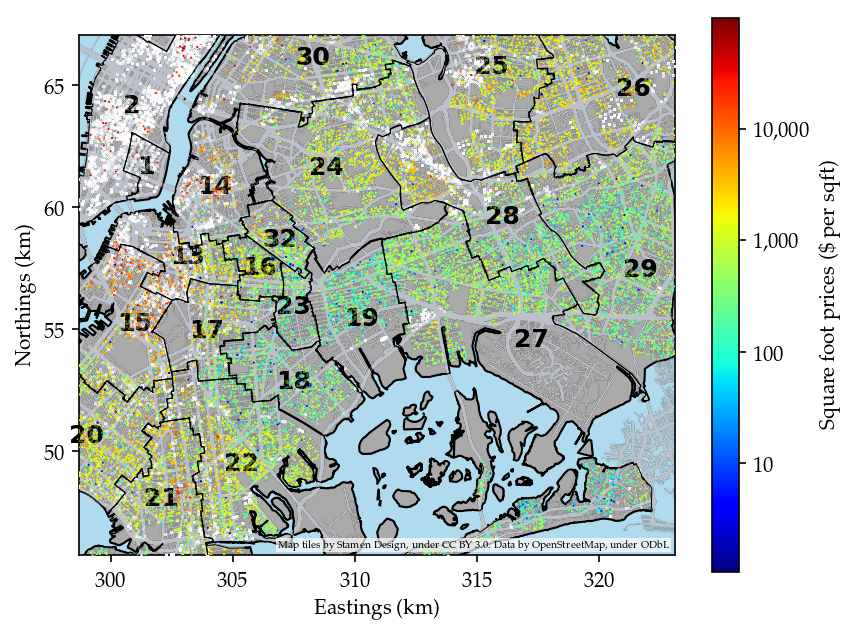

In [13]:
NYC.plot_sales(filtered[:filtered], missing_sqft; colorbar=true)
NYC.plot_streets(; zoom=12, rgb=(188, 193, 204))
plt.text(0.99, 0.01, "Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL",
    horizontalalignment="right",
    verticalalignment="bottom",
    fontsize=5,
    bbox=Dict(:edgecolor=>"none",:facecolor=>"white", :alpha=>0.7, :pad=>1.0),
    transform = plt.gca().transAxes, zorder=42)
if do_savefig
    plt.savefig(joinpath(figures_dir, "sales_map.pdf"), bbox_inches="tight")
    plt.savefig(joinpath(figures_dir, "sales_map.png"), bbox_inches="tight")
end
;

In [14]:
StatsBase.countmap(filtered[:filtered][!,NYC.BUILDING_CLASS_CATEGORY])

Dict{CategoricalString{UInt32},Int64} with 3 entries:
  CategoricalString{UInt32} "01  ONE FAMILY DWELLINGS"   => 9037
  CategoricalString{UInt32} "02  TWO FAMILY DWELLINGS"   => 8583
  CategoricalString{UInt32} "03  THREE FAMILY DWELLINGS" => 2364

In [15]:
# COUNTS OF
# BUILDING CLASS AT TIME OF SALE
# IN FILTERED DATA

building_class_dict = Dict{String,String}()
filename = joinpath(data_dir, "building_tax_class.txt")
open(filename) do io
    while true
        line = readline(io)
        line == "" && break
        code = strip(line[1:7])
        @assert length(code) == 2
        description = strip(line[8:end])
        building_class_dict[code] = description
   end
end
building_class_dict

description_count = Dict{String,Int}()
code_count = StatsBase.countmap(filtered[:filtered][!,NYC.BUILDING_CLASS_AT_TIME_OF_SALE])
for code in keys(code_count)
    description = building_class_dict[code]
    count = code_count[code]
    description_count[code*": "*description] = count
end
description_count

Dict{String,Int64} with 17 entries:
  "A4: CITY RESIDENCE ONE FAMILY"                   => 143
  "A1: TWO STORIES - DETACHED SM OR MID"            => 3677
  "S1: PRIMARILY 1 FAMILY WITH 1 STORE OR OFFICE"   => 189
  "A9: MISCELLANEOUS ONE FAMILY"                    => 782
  "B1: TWO FAMILY BRICK"                            => 2731
  "B9: MISCELLANEOUS TWO FAMILY"                    => 695
  "A7: MANSION TYPE OR TOWN HOUSE"                  => 6
  "A0: CAPE COD"                                    => 252
  "B3: TWO FAMILY CONVERTED FROM ONE FAMILY"        => 2384
  "S0: PRIMARILY 1 FAMILY WITH 2 STORES OR OFFICES" => 8
  "A3: LARGE SUBURBAN RESIDENCE"                    => 152
  "A6: SUMMER COTTAGE"                              => 23
  "C0: THREE FAMILIES"                              => 2364
  "S2: PRIMARILY 2 FAMILY WITH 1 STORE OR OFFICE"   => 422
  "B2: TWO FAMILY FRAME"                            => 2351
  "A2: ONE STORY - PERMANENT LIVING QUARTER"        => 1364
  "A5: ONE FAMILY A

In [16]:
StatsBase.countmap(missing_sqft[!,NYC.BUILDING_CLASS_CATEGORY])

Dict{CategoricalString{UInt32},Int64} with 10 entries:
  CategoricalString{UInt32} "15  CONDOS - 2-10 UNIT RESIDENTIAL" => 1282
  CategoricalString{UInt32} "12  CONDOS - WALKUP APARTMENTS"     => 799
  CategoricalString{UInt32} "01  ONE FAMILY DWELLINGS"           => 92
  CategoricalString{UInt32} "10  COOPS - ELEVATOR APARTMENTS"    => 13246
  CategoricalString{UInt32} "09  COOPS - WALKUP APARTMENTS"      => 2697
  CategoricalString{UInt32} "17  CONDO COOPS"                    => 1234
  CategoricalString{UInt32} "04  TAX CLASS 1 CONDOS"             => 1157
  CategoricalString{UInt32} "02  TWO FAMILY DWELLINGS"           => 28
  CategoricalString{UInt32} "13  CONDOS - ELEVATOR APARTMENTS"   => 12467
  CategoricalString{UInt32} "03  THREE FAMILY DWELLINGS"         => 15

# Model

I decided to define the outcome to be the log price per square foot. The model is a Gaussian Process in the spatial covariates on top of a ridge regression on the property covariates (building and tax class). Within a school district we can write the model as:

\begin{equation}
\begin{split}
    Y_i &= \log\del{ \frac{\saleprice_i}{\sqft_i}} =
             \mu_{\district\sbr{i}} + \beta_{1,\tax\sbr{i}} + \beta_{2,\building\sbr{i}}
                  + f_{\district\sbr{i}}(\svec_i) + \epsilon_i
    \\
    \epsilon_i &\sim \normal\del{0, \sigma_y^2} \\
    \mu_{j} &\sim \normal\del{0, \sigma_\mu^2} \\
    \beta_{1j},\beta_{2j} &\sim \normal\del{0, \sigma_\beta^2} \\
    f_j(\svec_i) &\sim \gp\del{0, k(\svec, \svec')} \\
    k(\svec, \svec') &= \sigmaf^2 \exp\cbr{ - \frac{(\svec-\svec')\trans(\svec-\svec')}{\ell}}
\end{split}
\end{equation}

A visual inspection of the house sales map above led me to focus on the boundary between districts 19 and 27. It's important to note that the boundary between the two districts is also part of the boundary between Brooklyn and Queens, so we won't be able to attribute a causal effect solely to the difference in school districts. A histogram of $Y$ in both districts also shows that marginally the house prices are very different.

In [17]:
fmla = StatsModels.@formula(logSalePricePerSQFT ~ GP(XCoord, YCoord) | SchDistr + BUILDING)

geordd_df = filtered[:filtered][:, [:logSalePricePerSQFT, :SchDistr, :XCoord, :YCoord]]
geordd_df[!,:BUILDING] = filtered[:filtered][!,NYC.BUILDING_CLASS_AT_TIME_OF_SALE]
geordd_df[!,:TAX]      = filtered[:filtered][!,NYC.TAX_CLASS_AT_TIME_OF_SALE]
nyc_rd = GeoRDD.regions_from_dataframe(fmla, geordd_df)

# assign shapes
for distr in keys(nyc_rd)
    nyc_rd[distr].shape = schdistr_shape_dict[distr]
end

In [18]:
k_mgpcv = Mat12Iso(log(2000.0), log(1.0))
k_wmean = k_mgpcv + GaussianProcesses.fix(Const(log(20.0)))
βkern = LinIso(log(1.0))
local_distrs = [18,19,23,24,25,26,27,28,29]
mgpcv = GeoRDD.MultiGPCovars(nyc_rd, local_distrs, k_wmean, βkern, log(1.0))
;

## histogram of districts 19 and 27

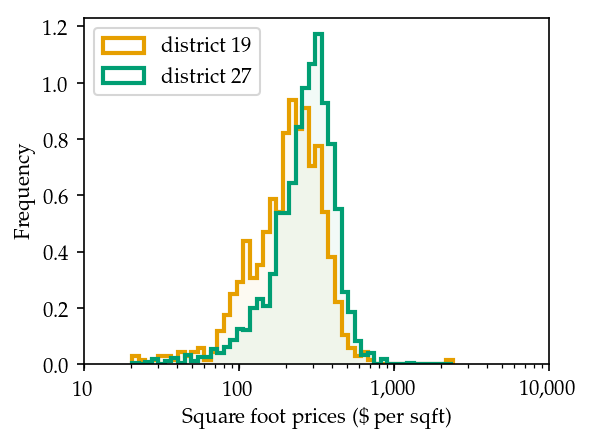

In [19]:
let 
    distrA = 19
    distrB = 27
    Y_A = nyc_rd[distrA].y
    Y_B = nyc_rd[distrB].y
    minY = min(minimum(Y_A), minimum(Y_B))
    maxY = max(maximum(Y_B), maximum(Y_A))
    Ybins = range(minY, maxY, length=50)
    plt.plt.hist(Y_A, 
        bins=Ybins, 
        histtype="step", 
        label=@sprintf("district %d", distrA), 
        normed=true,
        color=cbbPalette[1],
        alpha=1.0,
        linewidth=2)
    plt.plt.hist(Y_A, 
        bins=Ybins, 
        histtype="stepfilled", 
        normed=true,
        color=cbbPalette[1],
        alpha=0.05,
        zorder=-1,
        linewidth=0)
    plt.plt.hist(Y_B, 
        bins=Ybins, 
        histtype="step", 
        label=@sprintf("district %d", distrB), 
        normed=true,
        color=cbbPalette[3],
        alpha=1.0,
        linewidth=2)
    plt.plt.hist(Y_B, 
        bins=Ybins, 
        histtype="stepfilled",  
        normed=true,
        color=cbbPalette[3],
        alpha=0.05,
        zorder=-1,
        linewidth=2)
end
plt.xlabel("Square foot prices (\\\$ per sqft)")
plt.ylabel("Frequency")
plt.legend(loc="upper left")
tick_template = [1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.gca().set_xticks(log.([10, 100, 1000, 10000]))
plt.gca().set_xticks(log.([tick_template.*10; tick_template.*100; tick_template.*1000]), 
                       minor=true)
plt.gcf().set_size_inches(4.0, 3.0)
plt.gca().set_xticklabels([format(x, commas=true) for x in [10, 100, 1000, 10000]])
if do_savefig
    plt.savefig(joinpath(figures_dir, "sales_histogram_19-27.pdf"), bbox_inches="tight", transparent=true)
    plt.savefig(joinpath(figures_dir, "sales_histogram_19-27.png"), bbox_inches="tight", transparent=true)
end
;

# Fitting the Gaussian process model

In [20]:
GeoRDD.set_params!(mgpcv,
        [-0.926039, 9.828, -1.23708, 1.97756], # output of previous optimization run
        noise=true,
        kern=true,
        domean=false,
        beta=true
        )
;

In [21]:
# takes a few hours
@time opt_output=optimize!(
        mgpcv, 
        noise=true,
        kern=true,
        domean=false,
        beta=true,
        options=Optim.Options(
            show_trace=true,
            iterations=1000,
            x_tol=1e-8,
            f_tol=1e-10),
    )
opt_output

Iter     Function value   Gradient norm 
     0     6.616419e+03     1.742138e+03
 * time: 0.007047891616821289
     1     6.549217e+03     1.142876e+02
 * time: 476.1401550769806
     2     6.548893e+03     1.746874e+00
 * time: 581.432058095932
     3     6.548890e+03     9.104511e+00
 * time: 680.0759370326996
     4     6.548867e+03     1.697307e+00
 * time: 781.5609269142151
     5     6.548866e+03     6.113746e+00
 * time: 892.4133310317993
     6     6.548855e+03     2.963640e+00
 * time: 1000.8422930240631
     7     6.548851e+03     1.039057e+01
 * time: 1118.242625951767
     8     6.548828e+03     3.791563e+00
 * time: 1217.3322169780731
     9     6.548823e+03     1.220413e+01
 * time: 1312.7932069301605
    10     6.548800e+03     1.995018e+00
 * time: 1392.659471988678
    11     6.548797e+03     9.008896e+00
 * time: 1472.528084039688
    12     6.548787e+03     1.745264e+00
 * time: 1556.7154099941254
    13     6.548783e+03     9.549856e+00
 * time: 1635.265907049179
 

 * Status: success

 * Candidate solution
    Minimizer: [-8.47e-01, 9.44e+00, -1.40e+00,  ...]
    Minimum:   6.548574e+03

 * Found with
    Algorithm:     Conjugate Gradient
    Initial Point: [-9.26e-01, 9.83e+00, -1.24e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.14e-04 ≰ 1.0e-08
    |x - x'|/|x'|          = 1.21e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.16e-07 ≰ 1.0e-10
    |f(x) - f(x')|/|f(x')| = 4.82e-11 ≰ 0.0e+00
    |g(x)|                 = 5.45e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   4894  (vs limit Inf)
    Iterations:    51
    f(x) calls:    131
    ∇f(x) calls:   90


In [22]:
ℓ = (mgpcv.kernel.kleft.ℓ)
@printf("σ_y: %.4f\n", exp(mgpcv.logNoise))
@printf("σ_f: %.4f\n", √(mgpcv.kernel.kleft.σ2))
@printf("σ_β: %.4f\n", 1/√mgpcv.βkern.ℓ2)
@printf("ℓ: %.4f ft\n", ℓ)
@printf("ℓ: %.4f km\n", ℓ / 3280.84)


σ_y: 0.4286
σ_f: 0.2461
σ_β: 0.1304
ℓ: 12581.9274 ft
ℓ: 3.8350 km


## Get posterior mean $\beta$ using multiple districts

In [23]:
@time βhat = GeoRDD.postmean_β(mgpcv);
# βhat_dict=Dict(zip(coefnames(mf), βhat))

 14.019512 seconds (3.16 M allocations: 1.894 GiB, 13.48% gc time)


## Fit residuals with new $\hat\beta$ and hyperparameters

In [24]:
# obtain the residuals within each district
residuals_rd = empty(nyc_rd)
for key in keys(nyc_rd)
    residuals_rd[key] = GeoRDD.residuals_data(nyc_rd[key], βhat)
end

In [25]:
resid_GP_dict = GeoRDD.GPRealisations(residuals_rd, mgpcv.kernel, mgpcv.logNoise)
;

# cliff-face

In [26]:
distrA,distrB=19,27
border = GeoRDD.get_border(nyc_rd[distrA], nyc_rd[distrB], 10.0)
sentinels = GeoRDD.sentinels(border, 100)
μpost, Σpost = GeoRDD.cliff_face(resid_GP_dict[distrA], 
                                 resid_GP_dict[distrB],
                                 sentinels)
;

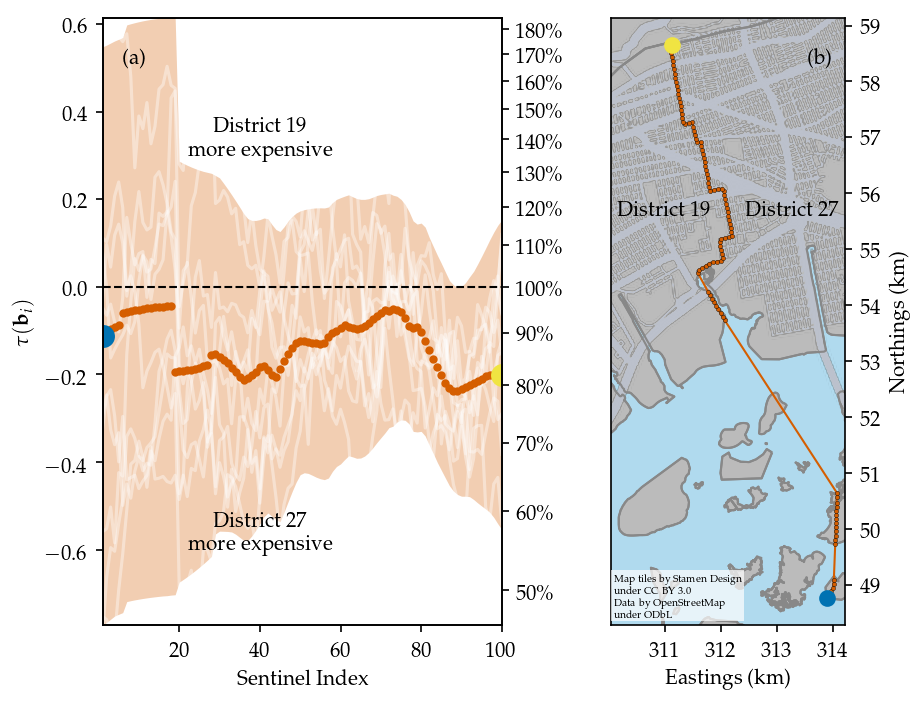

In [27]:
distrA = 19
distrB = 27
msize = 7 # size of first sentinel / last sentinel marker
ax = plt.gca()
plt.subplot(1,2,2)
### Map of sentinels

plt.plot(sentinels[1,:], sentinels[2,:], linewidth=1, 
        linestyle="-", marker="o", 
        markeredgecolor="black",
        markeredgewidth=0.2,
        markersize=2, 
        color=cbbPalette[6])
plt.plot(sentinels[1,1], sentinels[2,1], "o", color=cbbPalette[5], markersize=msize, label="first point")
plt.plot(sentinels[1,end], sentinels[2,end], "o", color=cbbPalette[4], markersize=msize, label="last point")
plt.text(sentinels[1,50]+1000,sentinels[2,50], "District 27", horizontalalignment="left")
plt.text(sentinels[1,50]-1000,sentinels[2,50], "District 19", horizontalalignment="right")
ax.set_aspect("equal")
plt.xlim(plt.xlim()[1]-3000,plt.xlim()[2])
_xlim = plt.xlim()
_ylim = plt.ylim()

NYC.background_schdistrs(plt.gca(),
            color="#BBBBBB", 
            edgecolor="#888888",
            alpha=1.0,
            linestyle="-",
            linewidth=1,
            zorder=-10
            )
NYC.plot_streets(; zoom=12, rgb=(188, 193, 204), zorder=-8)
NYC.background_schdistrs(plt.gca(),
            color="none", 
            edgecolor="#888888",
            alpha=1.0,
            linestyle="-",
            linewidth=1,
            zorder=-6
            )
plt.text(0.01, 0.01, "Map tiles by Stamen Design\nunder CC BY 3.0\nData by OpenStreetMap\nunder ODbL",
    horizontalalignment="left",
    verticalalignment="bottom",
    fontsize=5,
    bbox=Dict(:edgecolor=>"none",:facecolor=>"white", :alpha=>0.7, :pad=>1.0),
    transform = plt.gca().transAxes, zorder=42)
plt.xlim(_xlim)
plt.ylim(_ylim)
NYC.ticks_km(1.0)
ax = plt.gca()
ax.set_facecolor("#B0DAEE")
NYC.yaxis_right()

NYC.title_in_axis("(b)", :right)

### Cliff Face

plt.subplot(1,2,1)
NYC.plot_cliffface(μpost,Σpost, cbbPalette[6])
plt.axhline(y=0, color="black", linewidth=1, linestyle="--")
plt.text(40, 0.3,  "District 19\nmore expensive", horizontalalignment="center")
plt.text(40, -0.6, "District 27\nmore expensive", horizontalalignment="center")
plt.ylabel(L"\tau(\mathbf{b}_i)")
plt.xlabel("Sentinel Index")
# plt.legend()
plt.tight_layout()
NYC.title_in_axis("(a)", :left)
if do_savefig
    plt.savefig(joinpath(figures_dir, "NYC_cliff_face.pdf"), bbox_inches="tight")
    plt.savefig(joinpath(figures_dir, "NYC_cliff_face.png"), bbox_inches="tight")
end
;

## surface plot

In [28]:
distrA,distrB=19,27
border = GeoRDD.get_border(nyc_rd[distrA], nyc_rd[distrB], 10.0)
sentinels = GeoRDD.sentinels(border, 100)
gridspace= 200.0 # feet
gridA = GeoRDD.region_grid(schdistr_shape_dict[distrA], gridspace)
gridB = GeoRDD.region_grid(schdistr_shape_dict[distrB], gridspace)

gpA = resid_GP_dict[distrA]
gpB = resid_GP_dict[distrB]
predgridA=GaussianProcesses.predict_f(gpA, gridA; full_cov=false)[1]
predgridB=GaussianProcesses.predict_f(gpB, gridB; full_cov=false)[1]
predA_b = GaussianProcesses.predict_f(gpA, sentinels; full_cov=false)[1]
predB_b = GaussianProcesses.predict_f(gpB, sentinels; full_cov=false)[1]
;

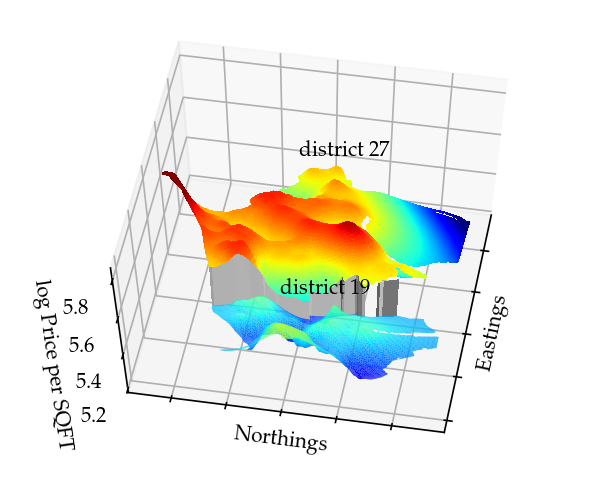

In [29]:
plt.gcf().set_size_inches(5.0, 4.0)
NYC.plot_surface3d(gridA, gridB, predgridA, predgridB, predA_b, predB_b, 
               sentinels, 
               schdistr_shape_dict[distrA],
               schdistr_shape_dict[distrB];
               xlim=(1.000e6, 1.20e6),
               ylim=(0.172e6, 0.203e6),
               labelT="district 19",
               labelC="district 27"
               )
ax = plt.gca()
ax.dist = 10
ax.xaxis.labelpad = -10.0
ax.yaxis.labelpad = -10.0
ax.zaxis.labelpad = 1.0
ax.view_init(elev=60, azim=190)
if do_savefig
    plt.savefig(joinpath(figures_dir, "NYC_surface_plot.pdf"), bbox_inches="tight", transparent=true)
    plt.savefig(joinpath(figures_dir, "NYC_surface_plot.png"), bbox_inches="tight", transparent=true)
end

# Average treatment effect

## Unweighted mean treatment effect

In [30]:
τ_unif=GeoRDD.unweighted_mean(μpost, Σpost)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τ_unif), std(τ_unif))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τ_unif, 0.0)*100)

τ|Y ∼ Normal(μ=-0.136, σ=0.095)
P(τ>0|Y) = 7.633%

## Finite-population method

In [31]:
maxdist = 1ℓ
τpost_proj = GeoRDD.proj_estimator(resid_GP_dict[distrA], 
                                   resid_GP_dict[distrB], 
                                   border,
                                   maxdist)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τpost_proj), std(τpost_proj))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τpost_proj, 0.0)*100)

τ|Y ∼ Normal(μ=-0.137, σ=0.079)
P(τ>0|Y) = 4.140%

## Inverse variance

In [32]:
τ_inv=GeoRDD.inverse_variance(μpost, Σpost)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τ_inv), std(τ_inv))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τ_inv, 0.0)*100)

τ|Y ∼ Normal(μ=-0.152, σ=0.067)
P(τ>0|Y) = 1.184%

## Geographic projection estimator

In [33]:
distrA, distrB = 19, 27
border = GeoRDD.get_border(nyc_rd[distrA], nyc_rd[distrB], 10.0)
region = LibGEOS.union(schdistr_shape_dict[distrA], schdistr_shape_dict[distrB])
@time τ_geo = GeoRDD.infinite_proj_estim(resid_GP_dict[distrA], 
                                   resid_GP_dict[distrB], 
                                   border,
                                   region,
                                   maxdist,
                                   ℓ/10,
                                   )
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τ_geo), std(τ_geo))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τ_geo, 0.0)*100)

  3.682937 seconds (978.79 k allocations: 54.800 MiB, 0.49% gc time)
τ|Y ∼ Normal(μ=-0.132, σ=0.118)
P(τ>0|Y) = 13.173%

## Population density

In [34]:
gp_T = resid_GP_dict[distrA]
gp_C = resid_GP_dict[distrB]
X_both = [gp_T.x gp_C.x]
kde_1927 = kde(X_both')
density_1927 = (s1,s2) -> pdf(kde_1927, s1, s2)

#13 (generic function with 1 method)

In [35]:
@time τ_pop = GeoRDD.infinite_proj_estim(resid_GP_dict[distrA], 
                                   resid_GP_dict[distrB], 
                                   border,
                                   region,
                                   maxdist,
                                   ℓ/10
                                   ;
                                   density=density_1927
                                   )
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τ_pop), std(τ_pop))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τ_pop, 0.0)*100)

  6.557309 seconds (5.36 M allocations: 895.741 MiB, 3.85% gc time)
τ|Y ∼ Normal(μ=-0.136, σ=0.076)
P(τ>0|Y) = 3.624%

## Border density

In [36]:
stnl_ρ = [density_1927(sentinels[1,i], sentinels[2,i]) for i in 1:size(sentinels,2)]
τ_rho = GeoRDD.weighted_mean(μpost, Σpost, stnl_ρ)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τ_rho), std(τ_rho))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τ_rho, 0.0)*100)

τ|Y ∼ Normal(μ=-0.148, σ=0.068)
P(τ>0|Y) = 1.541%

## Tables of Estimates

In [37]:
labels = [L"\unifavg", L"\taurho", L"\invvar", L"\tauproj", L"\taugeo", L"\taupop"]
estimators = [τ_unif, τ_rho, τ_inv, τpost_proj, τ_geo, τ_pop]
nyc_estimates = DataFrame()
nyc_estimates[!,:estimand] = labels
nyc_estimates[!,:mean] = [@sprintf("%.2f", mean(est)) for est in estimators]
nyc_estimates[!,:std] =  [@sprintf("%.2f", std(est)) for est in estimators]
nyc_estimates[!,:tail] = [@sprintf("%.2f%%", ccdf(est, 0.0)*100) for est in estimators]
nyc_estimates

,estimand,mean,std,tail
,LaTeXStr…,String,String,String
1,$\\unifavg$,-0.14,0.10,7.63%
2,$\\taurho$,-0.15,0.07,1.54%
3,$\\invvar$,-0.15,0.07,1.18%
4,$\\tauproj$,-0.14,0.08,4.14%
5,$\\taugeo$,-0.13,0.12,13.17%
6,$\\taupop$,-0.14,0.08,3.62%


In [38]:
print(repr("text/latex", nyc_estimates))

\begin{tabular}{r|cccc}
	& estimand & mean & std & tail\\
	\hline
	& LaTeXStr… & String & String & String\\
	\hline
	1 & $\unifavg$ & -0.14 & 0.10 & 7.63\% \\
	2 & $\taurho$ & -0.15 & 0.07 & 1.54\% \\
	3 & $\invvar$ & -0.15 & 0.07 & 1.18\% \\
	4 & $\tauproj$ & -0.14 & 0.08 & 4.14\% \\
	5 & $\taugeo$ & -0.13 & 0.12 & 13.17\% \\
	6 & $\taupop$ & -0.14 & 0.08 & 3.62\% \\
\end{tabular}


# Significance Tests

## $\chi^2$ bootstrap test

In [39]:
Random.seed!(1) # for reproducibility
distrA, distrB = 19, 27
@time pval_chi2 = GeoRDD.boot_chi2test(resid_GP_dict[distrA], resid_GP_dict[distrB],
                     sentinels,
                     10000) # number of bootstrap samples

 86.456009 seconds (1.23 M allocations: 1.668 GiB, 0.90% gc time)


0.1237

## mll bootstrap test

In [40]:
Random.seed!(1) # for reproducibility
distrA, distrB = 19, 27
@time pval_mll = GeoRDD.boot_mlltest(
    resid_GP_dict[distrA],
    resid_GP_dict[distrB],
    10000 # number of bootstrap samples
)

184.776043 seconds (1.17 M allocations: 3.145 GiB, 0.52% gc time)


0.0691

## inv-var test

In [41]:
pval_invvar_calib = GeoRDD.pval_invvar_calib(
    resid_GP_dict[distrA],
    resid_GP_dict[distrB],
    sentinels
)

0.03994712948207193

In [42]:
# uncalibrated
GeoRDD.pval_invvar_uncalib(
    resid_GP_dict[distrA],
    resid_GP_dict[distrB],
    sentinels
)

0.02368633931107818

## Placebos

In [43]:
function plot_placebo_pval_hist(pvalA, pvalB, pval_obs; plot_obs=true, label_unif=true)
    bins = range(0,1,length=10)
    plt.plt.hist(pvalA, bins=bins, linewidth=2, 
        color=cbbPalette[1], label=@sprintf("district %s", distrA), 
        histtype="step",
        alpha=1.0,
        )
    plt.plt.hist(pvalB, bins=bins, linewidth=2, 
        color=cbbPalette[2], label=@sprintf("district %s", distrB), 
        alpha=1.0,
        histtype="step",
        )
    plt.plt.hist(pvalA, bins=bins, linewidth=0, 
        color=cbbPalette[1],
        histtype="stepfilled",
        alpha=0.05,
        zorder=-1,
        )
    plt.plt.hist(pvalB, bins=bins, linewidth=0, 
        color=cbbPalette[2],
        alpha=0.05,
        zorder=-1,
        histtype="stepfilled",
        )
    if plot_obs
        plt.axvline(pval_obs, color=cbbPalette[3], label="observed", linewidth=3)
    end
    plt.axhline(length(pvalB)/length(bins), color="#333333", linestyle="--")
    if label_unif
        plt.text(y=length(pvalB)/length(bins) + 0.1, 
                 x=0.02,
                 s="Uniform",
                 color="#333333",
                 horizontalalignment="left",
                 verticalalignment="bottom",
                 rotation=0)
    end
    plt.xlabel("p-value")
    plt.ylabel("Count")
    plt.xlim(0,1)
end
function plot_placebo_pval_horiz_hist(pvalA, pvalB, pval_obs; plot_obs=true, label_unif=true)
    bins = range(0,1, length=10)
    plt.plt.hist(pvalA, bins=bins, linewidth=2, 
        color=cbbPalette[1], label=@sprintf("district %s", distrA), 
        alpha=1.0,
        histtype="step",
        orientation="horizontal",
        )
    plt.plt.hist(pvalB, bins=bins, linewidth=2, 
        color=cbbPalette[2], label=@sprintf("district %s", distrB), 
        alpha=1.0,
        histtype="step",
        orientation="horizontal"
        )
    plt.plt.hist(pvalA, bins=bins, linewidth=0, 
        color=cbbPalette[1], 
        alpha=0.05,
        histtype="stepfilled",
        zorder=-1,
        orientation="horizontal",
        )
    plt.plt.hist(pvalB, bins=bins, linewidth=0, 
        color=cbbPalette[2],
        alpha=0.05,
        histtype="stepfilled",
        zorder=-1,
        orientation="horizontal"
        )
    if plot_obs
        plt.axhline(pval_obs, color=cbbPalette[3], label="observed", linewidth=3)
    end
    plt.axvline(length(pvalB)/length(bins), color="#333333", linestyle="-")
    if label_unif
        plt.text(x=length(pvalB)/length(bins) + 0.1, 
                 y=0.98,
                 s="Uniform",
                 color="#333333",
                 horizontalalignment="left",
                 verticalalignment="top",
                 rotation=-90)
    end
    plt.ylabel("p-value")
    plt.xlabel("Count")
    plt.ylim(0,1)
end
function plot_placebo_pval_trace(x_angle, pvalA, pvalB, pval_obs; plot_obs=true)
    plt.plot(x_angle, pvalA, color=cbbPalette[1], label=@sprintf("district %s", distrA), 
             linewidth=1, marker="p", markersize=4,)
    plt.plot(x_angle, pvalB, color=cbbPalette[2], label=@sprintf("district %s", distrB), 
             linewidth=1, marker="p", markersize=4)
    if plot_obs
        plt.axhline(pval_obs, color=cbbPalette[3], label="observed", linewidth=3)
    end
    plt.xlabel("Angle (degrees)")
    plt.gca().get_xaxis().set_ticks(collect(0:30:180))
    plt.ylabel("p-value")
    plt.ylim(0,1)
end
function plot_placebo_pval(x_angle, pvalA, pvalB, pval_obs, title)
    plt.subplot(1,2,1)
    plot_placebo_pval_hist(pvalA, pvalB, pval_obs)
    plt.legend(loc="upper right")
    plt.title(title)

    plt.subplot(1,2,2)
    plot_placebo_pval_trace(x_angle, pvalA, pvalB, pval_obs)
end
;

In [44]:
distrA = 19
distrB = 27

@time placebo_mll_A = [GeoRDD.placebo_mll(angle, resid_GP_dict[distrA], 1000)
                       for angle in 1.:2.:180.]
;

 81.769505 seconds (4.58 M allocations: 8.012 GiB, 1.67% gc time)


In [45]:
@time placebo_mll_B = [GeoRDD.placebo_mll(angle, resid_GP_dict[distrB], 1000)
                       for angle in 1.:2.:180.]
;

953.065615 seconds (3.29 M allocations: 35.882 GiB, 3.77% gc time)


In [46]:
@time placebo_chi_A = [GeoRDD.placebo_chi(angle, resid_GP_dict[distrA], 1000)
                       for angle in 1.:2.:180.]
;

 42.046457 seconds (5.31 M allocations: 5.572 GiB, 2.26% gc time)


In [47]:
@time placebo_chi_B = [GeoRDD.placebo_chi(angle, resid_GP_dict[distrB], 1000)
                       for angle in 1.:2.:180.]
;

478.286367 seconds (2.78 M allocations: 26.550 GiB, 7.61% gc time)


In [48]:
@time placebo_invvar_A = [GeoRDD.placebo_invvar(angle, resid_GP_dict[distrA]) for angle in 1.:2.:180.];

  3.180655 seconds (1.25 M allocations: 1.420 GiB, 15.83% gc time)


In [49]:
@time placebo_invvar_B = [GeoRDD.placebo_invvar(angle, resid_GP_dict[distrB]) for angle in 1.:2.:180.];

 19.184783 seconds (147.71 k allocations: 10.773 GiB, 13.43% gc time)


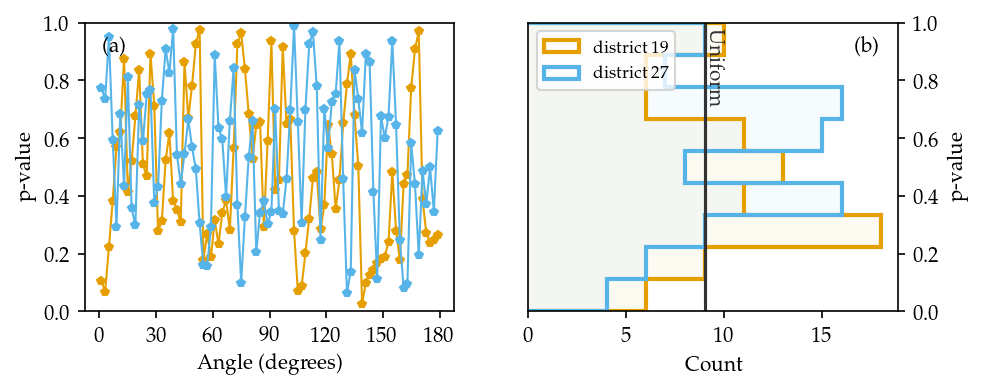

In [50]:
plt.subplot(1,2,1)
plot_placebo_pval_trace(1:2:180, placebo_invvar_A, placebo_invvar_B, pval_invvar_calib; plot_obs=false)
NYC.title_in_axis("(a)", :left)
plt.subplot(1,2,2)
plot_placebo_pval_horiz_hist(placebo_invvar_A, placebo_invvar_B, pval_invvar_calib; plot_obs=false, label_unif=true)
NYC.yaxis_right()
NYC.title_in_axis("(b)", :right)
plt.legend(loc="upper left", fontsize="small")
plt.gcf().set_size_inches(7.0, 2.5)
if do_savefig
    plt.savefig(joinpath(figures_dir, "placebo_invvar.pdf"), bbox_inches="tight")
    plt.savefig(joinpath(figures_dir, "placebo_invvar.png"), bbox_inches="tight")
end
;

### plot 3x2

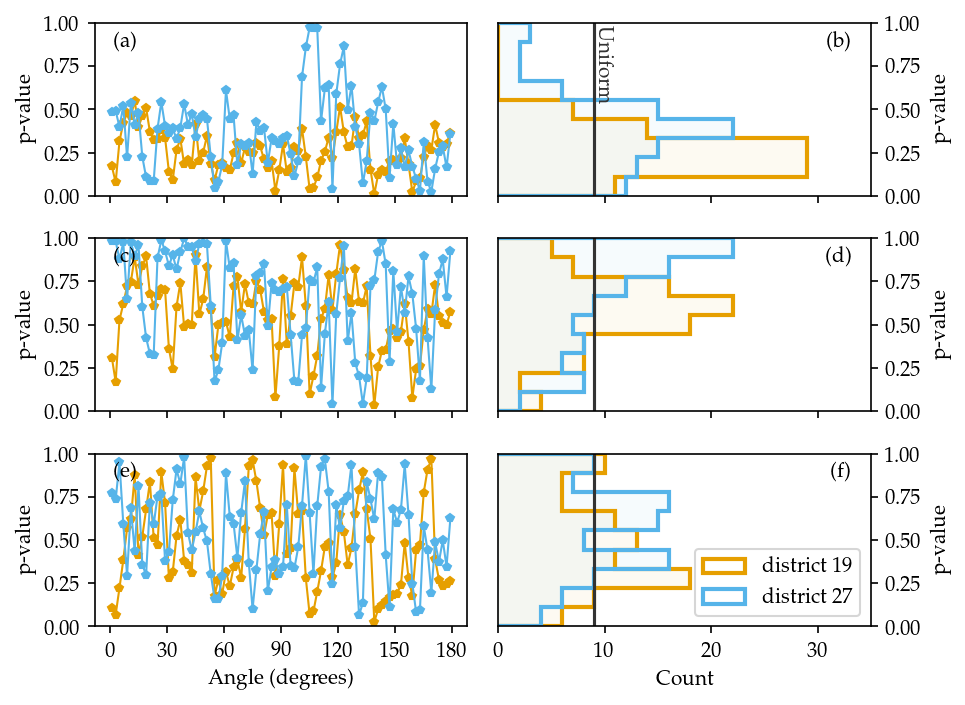

In [51]:
plt.subplot(3,2,1)
plot_placebo_pval_trace(1:2:180, placebo_mll_A, placebo_mll_B, pval_mll; plot_obs=false)
NYC.hide_xaxis()
NYC.title_in_axis("(a)", :left)
plt.subplot(3,2,2)
plot_placebo_pval_horiz_hist(placebo_mll_A, placebo_mll_B, pval_mll; plot_obs=false, label_unif=true)
NYC.yaxis_right()
plt.xlim(0, 35)
NYC.hide_xaxis()
NYC.title_in_axis("(b)", :right)

plt.subplot(3,2,3)
plot_placebo_pval_trace(1:2:180, placebo_chi_A, placebo_chi_B, pval_chi2; plot_obs=false)
NYC.hide_xaxis()
NYC.title_in_axis("(c)", :left)
plt.subplot(3,2,4)
plot_placebo_pval_horiz_hist(placebo_chi_A, placebo_chi_B, pval_chi2; plot_obs=false, label_unif=false)
NYC.yaxis_right()
plt.xlim(0, 35)
NYC.hide_xaxis()
NYC.title_in_axis("(d)", :right)

plt.subplot(3,2,5)
plot_placebo_pval_trace(1:2:180, placebo_invvar_A, placebo_invvar_B, pval_invvar_calib; plot_obs=false)
NYC.title_in_axis("(e)", :left)
plt.subplot(3,2,6)
plot_placebo_pval_horiz_hist(placebo_invvar_A, placebo_invvar_B, pval_invvar_calib; plot_obs=false, label_unif=false)
NYC.yaxis_right()
plt.xlim(0, 35)
NYC.title_in_axis("(f)", :right)
plt.legend(loc="lower right")

plt.gcf().tight_layout()
if do_savefig
    plt.savefig(joinpath(figures_dir, "NYC_placebos.pdf"), bbox_inches="tight")
    plt.savefig(joinpath(figures_dir, "NYC_placebos.png"), bbox_inches="tight")
end

# Pairwise treatment effect

So far we've focused on just district 19 and 27. We now estimate the treatment affect for every pair of adjacent districts.

In [52]:
τpost_pairs = Dict{Tuple{NYC.SchDistr,NYC.SchDistr},Normal}()
pval_pairs = Dict{Tuple{NYC.SchDistr,NYC.SchDistr},Float64}()
for pair_border in GeoRDD.adjacent_pairs(nyc_rd, 10.0)
    pair, border = pair_border
    schdistr_i, schdistr_j = pair
    print(schdistr_i, "-", schdistr_j, " ")
    # obtain 100 sentinel positions along the border
    sentinels = GeoRDD.sentinels(border, 100)
    # get the fitted Gaussian processes
    gpA = resid_GP_dict[schdistr_i]
    gpB = resid_GP_dict[schdistr_j]
    # obtain the cliff-face estimator
    μ, Σ = GeoRDD.cliff_face(gpA, gpB, sentinels)
    # obtain the inverse-variance weighted local average treatment effect
    τpost = GeoRDD.inverse_variance(μ, Σ)
    # store in dictionary
    τpost_pairs[schdistr_i,schdistr_j] = τpost
    τpost_pairs[schdistr_j,schdistr_i] = Normal(-mean(τpost), std(τpost))
    # and p-values
    pval = GeoRDD.pval_invvar_calib(gpA, gpB, sentinels)
    pval_pairs[schdistr_i,schdistr_j] = pval
    pval_pairs[schdistr_j,schdistr_i] = pval
end

18-19 18-17 18-22 18-23 30-25 30-24 32-16 32-19 32-24 32-23 32-14 2-4 2-3 2-1 16-17 16-23 16-13 16-14 11-8 11-12 21-22 21-20 7-9 7-8 9-8 9-12 25-26 25-29 25-24 25-28 26-29 29-28 29-27 19-24 19-23 19-27 17-22 17-23 17-13 17-15 8-12 22-20 22-15 6-5 24-28 24-14 24-27 4-3 4-5 3-5 28-27 20-15 13-14 13-15 

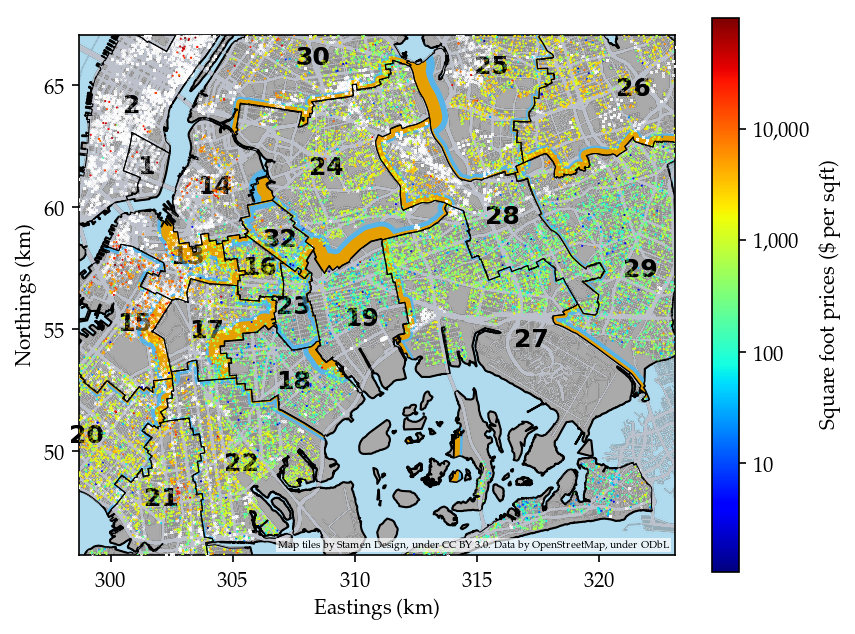

In [53]:
plt.gcf().set_size_inches(7.0, 5.0)
NYC.plot_sales(filtered[:filtered], missing_sqft; colorbar=true)
_xlim = plt.xlim()
_ylim = plt.ylim()
NYC.plot_all_pairs(τpost_pairs, nyc_rd; 
    scaleup=5000.0, zorder=5)
plt.xlim(_xlim)
plt.ylim(_ylim)
NYC.plot_streets(; zoom=12, rgb=(188, 193, 204))
plt.text(0.99, 0.01, "Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL",
    horizontalalignment="right",
    verticalalignment="bottom",
    fontsize=5,
    bbox=Dict(:edgecolor=>"none",:facecolor=>"white", :alpha=>0.7, :pad=>1.0),
    transform = plt.gca().transAxes, zorder=42)
if do_savefig
    plt.savefig(joinpath(figures_dir, "pairwise_mean_se.pdf"), bbox_inches="tight")
    plt.savefig(joinpath(figures_dir, "pairwise_mean_se.png"), bbox_inches="tight")
end
;

In [54]:
τ_pair_nested = Dict{NYC.SchDistr, Dict{NYC.SchDistr, Normal}}()
include_distr = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32]
for distr in keys(nyc_rd)
    # initialize
    if distr ∉ include_distr
        continue
    end
    τ_pair_nested[distr] = Dict{NYC.SchDistr, Normal}()
end
for (distrA, distrB) in keys(τpost_pairs)
    τpost = τpost_pairs[distrA, distrB]
    if distrA ∉ include_distr
        continue
    end
    if distrB ∉ include_distr
        continue
    end
    τ_pair_nested[distrA][distrB] = τpost
end
;
npairs = 0
for distrA in sort(collect(keys(τ_pair_nested)))
    if isempty(τ_pair_nested[distrA])
        continue
    end
    @printf("\\( \\mathbf{%2d} \\) \\vspace{-0.7ex} ", distrA)
    for distrB in sort(collect(keys(τ_pair_nested[distrA])))
        τ = τ_pair_nested[distrA][distrB]
        @printf("& \\( \\mathbf{%2d:}~%+.2f \\pm %.2f \\)", distrB, -mean(τ), std(τ))
    end
    print("\\\\ \n ")
    for distrB in sort(collect(keys(τ_pair_nested[distrA])))
        pval = pval_pairs[distrA,distrB]
        if pval < 0.01
            pval_str = "<0.01"
        else
            pval_str = @sprintf("={%.2f}", pval)
        end
        @printf("& \\( (p%s) \\)", pval_str)
        npairs += 1
    end
    print("\\\\ \n")
end
@show npairs

\( \mathbf{13} \) \vspace{-0.7ex} & \( \mathbf{14:}~-0.33 \pm 0.10 \)& \( \mathbf{15:}~+0.01 \pm 0.08 \)& \( \mathbf{16:}~-0.20 \pm 0.08 \)& \( \mathbf{17:}~-0.08 \pm 0.09 \)\\ 
 & \( (p<0.01) \)& \( (p={0.89}) \)& \( (p={0.02}) \)& \( (p={0.39}) \)\\ 
\( \mathbf{14} \) \vspace{-0.7ex} & \( \mathbf{13:}~+0.33 \pm 0.10 \)& \( \mathbf{16:}~+0.10 \pm 0.13 \)& \( \mathbf{24:}~-0.29 \pm 0.21 \)& \( \mathbf{32:}~+0.04 \pm 0.14 \)\\ 
 & \( (p<0.01) \)& \( (p={0.46}) \)& \( (p={0.10}) \)& \( (p={0.79}) \)\\ 
\( \mathbf{15} \) \vspace{-0.7ex} & \( \mathbf{13:}~-0.01 \pm 0.08 \)& \( \mathbf{17:}~-0.28 \pm 0.12 \)& \( \mathbf{20:}~+0.04 \pm 0.07 \)& \( \mathbf{22:}~+0.05 \pm 0.15 \)\\ 
 & \( (p={0.89}) \)& \( (p={0.03}) \)& \( (p={0.56}) \)& \( (p={0.70}) \)\\ 
\( \mathbf{16} \) \vspace{-0.7ex} & \( \mathbf{13:}~+0.20 \pm 0.08 \)& \( \mathbf{14:}~-0.10 \pm 0.13 \)& \( \mathbf{17:}~+0.06 \pm 0.09 \)& \( \mathbf{23:}~-0.05 \pm 0.09 \)& \( \mathbf{32:}~+0.10 \pm 0.09 \)\\ 
 & \( (p={0.02}) \)& \( (p

80